# Машинное обучение – весна 2025

# Домашнее задание 2: Деревья. Случайный лес. Бустинг.

Правила:

- Домашнее задание оценивается в 20 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [4]:
p1 = 0.8
p2 = 0.2

entropy = -p1 * np.log(p1) - p2 * np.log(p2)
print(f"Энтропия: {entropy:.2f}")

Энтропия: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [5]:
p1_m = 8 / 10
p2_m = 2 / 10
H_Rm = p1_m * (1 - p1_m) + p2_m * (1 - p2_m)

p1_l = 1
p2_l = 0
H_Rl = p1_l * (1 - p1_l) + p2_l * (1 - p2_l)

p1_r = 0
p2_r = 1
H_Rr = p1_r * (1 - p1_r) + p2_r * (1 - p2_r)

Q = H_Rm - (8 / 10) * H_Rl - (2 / 10) * H_Rr

print(f"Критерий информативности: {Q:.2f}")

Критерий информативности: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
y_values = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
y_pred = np.mean(y_values)

print(f"Предсказания модели для объектов в листовой вершине: {y_pred:.2f}")

Предсказания модели для объектов в листовой вершине: 40.60


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [7]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [8]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    assert len(feature_vector) == len(target_vector)

    if task == "classification":
        p = np.mean(target_vector == target_vector[:, np.newaxis], axis=1)
        H = np.sum(p * (1 - p))
    else:
        H = np.var(target_vector)

    sorted_indices = np.argsort(feature_vector)
    feature_vector = feature_vector[sorted_indices]
    target_vector = target_vector[sorted_indices]

    if feature_type == "real":
        thresholds = (feature_vector[:-1] + feature_vector[1:]) / 2
    else:
        thresholds = np.unique(feature_vector)

    n = len(feature_vector)
    n_left = np.arange(1, n)
    n_right = n - n_left

    if task == "classification":
        p_left = np.cumsum(target_vector)[:-1] / n_left
        p_right = (np.sum(target_vector) - np.cumsum(target_vector)[:-1]) / n_right
        H_left = p_left * (1 - p_left)
        H_right = p_right * (1 - p_right)
    else:
        sum_left = np.cumsum(target_vector)[:-1]
        sum_right = np.sum(target_vector) - sum_left
        mean_left = sum_left / n_left
        mean_right = sum_right / n_right
        H_left = np.cumsum(target_vector**2)[:-1] - sum_left**2 / n_left
        H_right = (np.sum(target_vector**2) - np.cumsum(target_vector**2)[:-1]) - sum_right**2 / n_right

    impurity_gain = H - (n_left / n) * H_left - (n_right / n) * H_right

    best_index = np.argmax(impurity_gain)
    threshold_best = thresholds[best_index]
    gini_best = impurity_gain[best_index]

    return thresholds, impurity_gain, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [9]:
from sklearn.datasets import fetch_california_housing

In [10]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

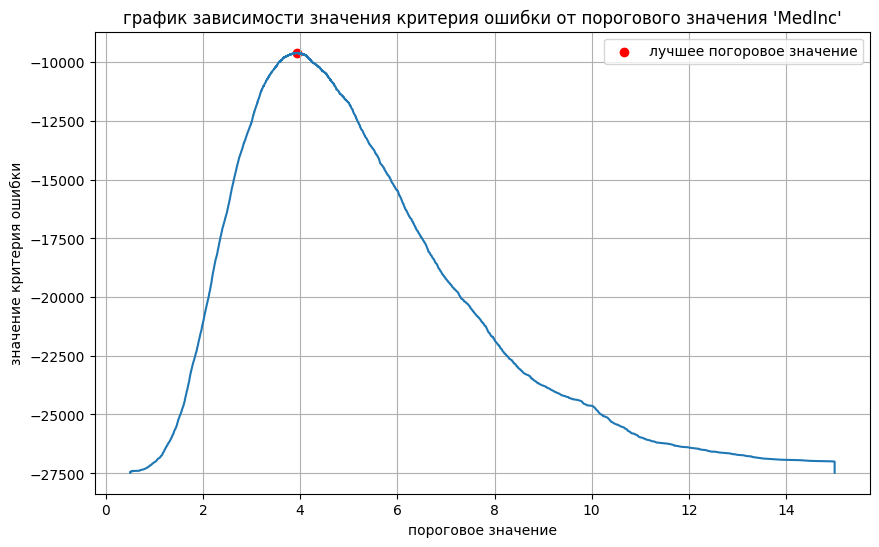

In [15]:
import matplotlib.pyplot as plt

feature = "MedInc"
feature_vector = X[feature].values

thresholds, ginis, threshold_best, gini_best = find_best_split(
    feature_vector, y, task="regression", feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis)
plt.xlabel("пороговое значение")
plt.ylabel("значение критерия ошибки")
plt.title(f"график зависимости значения критерия ошибки от порогового значения '{feature}'")
plt.scatter(threshold_best, gini_best, color="red", label="лучшее погоровое значение")
plt.legend()
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [16]:
best_feature = None
best_threshold = None
best_gini = -np.inf

for feature in X.columns:
    feature_vector = X[feature].values
    thresholds, ginis, threshold, gini = find_best_split(
        feature_vector, y, task="regression", feature_type="real"
    )
    if gini > best_gini:
        best_feature = feature
        best_threshold = threshold
        best_gini = gini

print(f"лучший признак для первой вершины: {best_feature}")
print(f"лучшее пороговое значение: {best_threshold}")
print(f"лучшее значение критерия ошибки: {best_gini}")

лучший признак для первой вершины: MedInc
лучшее пороговое значение: 3.93485
лучшее значение критерия ошибки: -9598.44238698406


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [153]:
class DecisionTree:
    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = {}

    def _find_best_split(self, feature_vector: np.ndarray, target_vector: np.ndarray, feature_type: str):
        if feature_type == "categorical":
            categories = np.unique(feature_vector)
            if len(categories) == 1:
                return None, None, None, -np.inf

            best_gini = -np.inf
            best_category = None

            for category in categories:
                left_mask = feature_vector == category
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gini = self._calculate_gini_gain(target_vector, left_mask)
                if gini > best_gini:
                    best_gini = gini
                    best_category = category

            return None, best_category, best_gini, None

        else:
            unique_values = np.unique(feature_vector)
            if len(unique_values) == 1:
                return None, None, None, -np.inf

            thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            best_gini = -np.inf
            best_threshold = None

            for threshold in thresholds:
                left_mask = feature_vector <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gini = self._calculate_gini_gain(target_vector, left_mask)
                if gini > best_gini:
                    best_gini = gini
                    best_threshold = threshold

            return best_threshold, None, best_gini, None

    def _calculate_gini_gain(self, target_vector: np.ndarray, left_mask: np.ndarray):
        n = len(target_vector)
        n_left = np.sum(left_mask)
        n_right = n - n_left

        if n_left == 0 or n_right == 0:
            return 0

        p_left = n_left / n
        p_right = n_right / n

        gini_left = 1 - np.sum((np.bincount(target_vector[left_mask]) / n_left) ** 2)
        gini_right = 1 - np.sum((np.bincount(target_vector[~left_mask]) / n_right) ** 2)

        gini_total = 1 - np.sum((np.bincount(target_vector) / n) ** 2)
        gini_gain = gini_total - (p_left * gini_left + p_right * gini_right)

        return gini_gain

    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict, depth: int = 0) -> None:
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, category_best, gini_best = None, None, None, -np.inf
        split = None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            threshold, category, gini, _ = self._find_best_split(
                sub_X[:, feature], sub_y, feature_type
            )

            if gini is not None and gini > gini_best:
                gini_best = gini
                feature_best = feature

                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold_best
                else:
                    category_best = category
                    split = sub_X[:, feature] == category_best

        if feature_best is None or gini_best <= 0:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        else:
            node["category_split"] = category_best

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        missing_mask = np.isnan(X)
        if np.any(missing_mask):
            for feature in range(X.shape[1]):
                if self._feature_types[feature] == "real":
                    X[missing_mask[:, feature], feature] = np.nanmedian(X[:, feature])
                elif self._feature_types[feature] == "categorical":
                    X[missing_mask[:, feature], feature] = Counter(X[~missing_mask[:, feature], feature]).most_common(1)[0][0]

        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

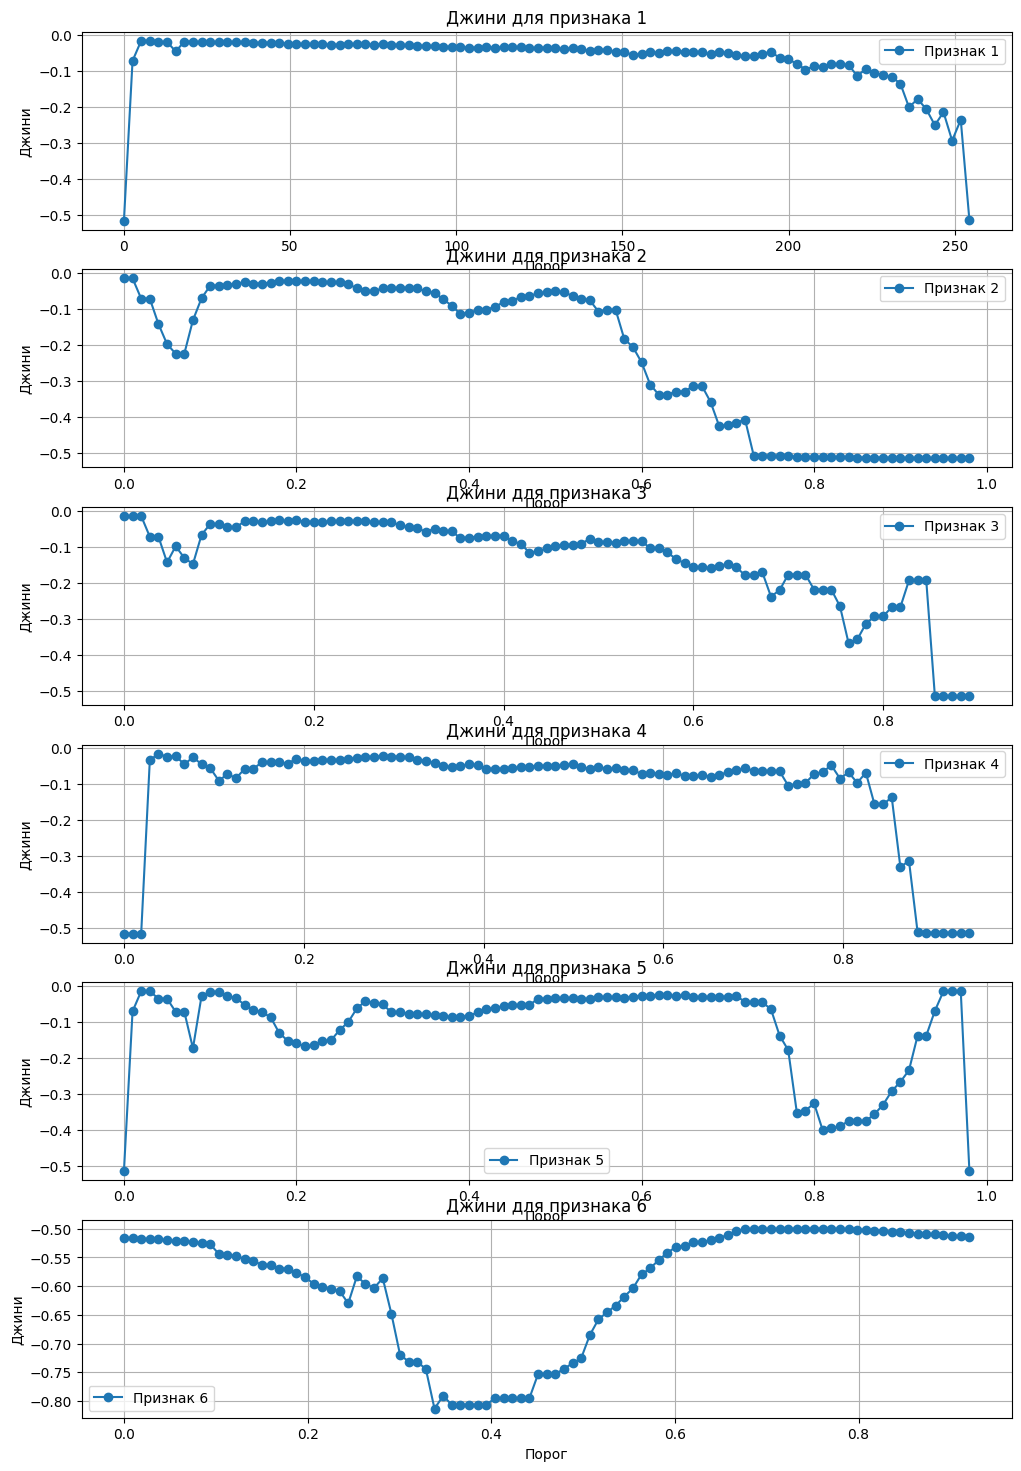

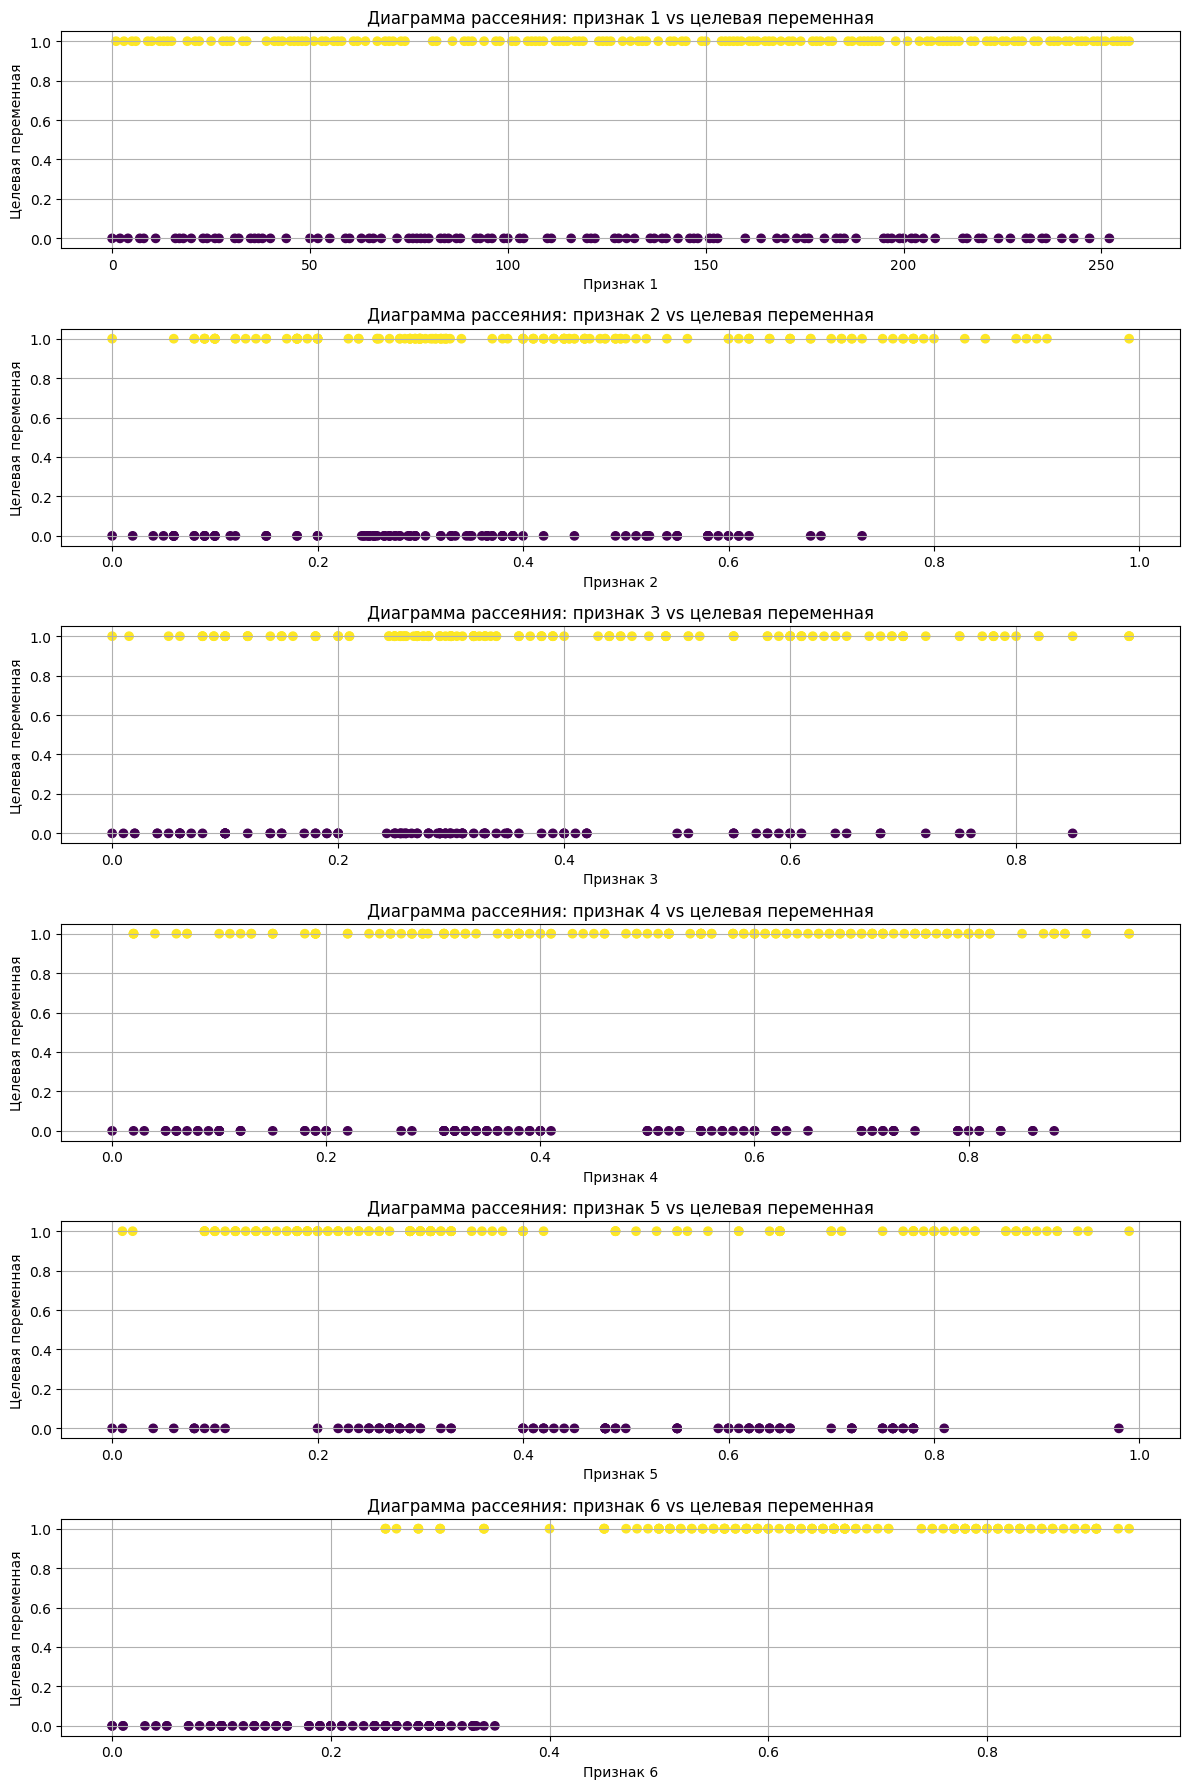

In [150]:
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("students.csv")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

clf = DecisionTreeClassifier(random_state=42)

thresholds = []
gini_values = []

for feature_index in range(X.shape[1]):
    thresholds.append([])
    gini_values.append([])

for feature_index in range(X.shape[1]):
    for threshold in np.linspace(X[:, feature_index].min(), X[:, feature_index].max(), 100):
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold

        if left_indices.sum() > 0 and right_indices.sum() > 0:
            left_y = y[left_indices]
            right_y = y[right_indices]

            left_counts = np.bincount(left_y)
            right_counts = np.bincount(right_y)

            left_p = left_counts / left_counts.sum()
            right_p = right_counts / right_counts.sum()

            gini_impurity = 1 - np.sum(left_p ** 2) - np.sum(right_p ** 2)
            thresholds[feature_index].append(threshold)
            gini_values[feature_index].append(gini_impurity)


plt.figure(figsize=(12, 3 * X.shape[1]))
for i in range(X.shape[1]):
    plt.subplot(X.shape[1], 1, i + 1)
    plt.plot(thresholds[i], gini_values[i], marker='o', linestyle='-', label=f'Признак {i+1}')
    plt.title(f'Джини для признака {i+1}')
    plt.xlabel('Порог')
    plt.ylabel('Джини')
    plt.grid(True)
    plt.legend()

plt.figure(figsize=(12, 3 * X.shape[1]))
for i in range(X.shape[1]):
    plt.subplot(X.shape[1], 1, i + 1)
    plt.scatter(X[:, i], y, c=y, cmap='viridis')
    plt.title(f'Диаграмма рассеяния: признак {i+1} vs целевая переменная')
    plt.xlabel(f'Признак {i+1}')
    plt.ylabel('Целевая переменная')
    plt.grid(True)

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Хороший признак - Глубокий минимум Gini (около 0). Можно выбрать чёткий порог.
       
Плохой признак - Gini всегда высокий. Нет хорошего порога для разделения.     

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [154]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from typing import Union, List

# Load and prepare the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]

data = pd.read_csv(url, header=None, names=column_names)

le = LabelEncoder()
encoded_data = data.apply(le.fit_transform)

X = encoded_data.drop('class', axis=1).values
y = encoded_data['class'].values

np.random.seed(42)
indices = np.random.permutation(len(X))
split_idx = len(X) // 2

train_idx, test_idx = indices[:split_idx], indices[split_idx:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [20]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [21]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

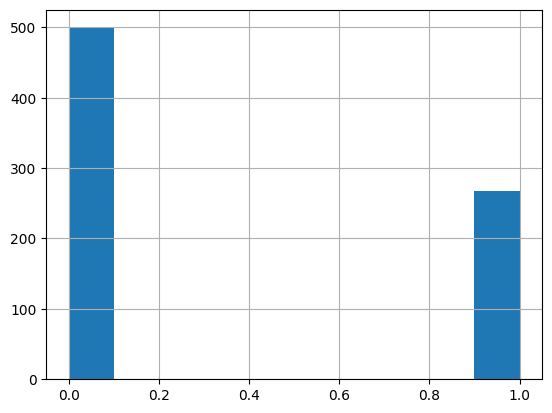

In [22]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [23]:
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(f"Размер обучающей-обучающей выборки: {X_train_train.shape}")
print(f"Размер обучающей-валидационной выборки: {X_train_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей-обучающей выборки: (375, 8)
Размер обучающей-валидационной выборки: (162, 8)
Размер тестовой выборки: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [24]:
from sklearn.metrics import f1_score

max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

best_f1 = 0
best_max_depth = None
best_min_samples_leaf = None

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree.fit(X_train_train, y_train_train)

        y_pred_val = tree.predict(X_train_val)

        f1 = f1_score(y_train_val, y_pred_val)

        if f1 > best_f1:
            best_f1 = f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf

print(f"Лучшие значения гиперпараметров: max_depth={best_max_depth}, min_samples_leaf={best_min_samples_leaf}")
print(f"Лучшая F1-мера: {best_f1}")

best_tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_tree.fit(X_train, y_train)

y_pred_test = best_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
auc_roc = roc_auc_score(y_test, y_pred_test)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")

Лучшие значения гиперпараметров: max_depth=7, min_samples_leaf=7
Лучшая F1-мера: 0.7142857142857143
Accuracy: 0.696969696969697
Precision: 0.5555555555555556
Recall: 0.625
AUC-ROC: 0.6800496688741722


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [27]:
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging.fit(X_train, y_train)

y_pred_test_bagging = bagging.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_test_bagging)
precision_bagging = precision_score(y_test, y_pred_test_bagging)
recall_bagging = recall_score(y_test, y_pred_test_bagging)
auc_roc_bagging = roc_auc_score(y_test, y_pred_test_bagging)

print("Метрики качества для BaggingClassifier:")
print(f"Accuracy: {accuracy_bagging}")
print(f"Precision: {precision_bagging}")
print(f"Recall: {recall_bagging}")
print(f"AUC-ROC: {auc_roc_bagging}")

Метрики качества для BaggingClassifier:
Accuracy: 0.7489177489177489
Precision: 0.6309523809523809
Recall: 0.6625
AUC-ROC: 0.7286009933774835


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
min_samples_split_values = [2, 4, 6, 8, 10, 12, 14]

best_f1_mean = 0
best_max_depth = None
best_min_samples_split = None


for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
        f1_mean = f1_scores.mean()

        if f1_mean > best_f1_mean:
            best_f1_mean = f1_mean
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split

print(f"Лучшие значения гиперпараметров: max_depth={best_max_depth}, min_samples_split={best_min_samples_split}")
print(f"Лучшая средняя F1-мера: {best_f1_mean}")

best_rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
best_rf.fit(X_train, y_train)

y_pred_test_rf = best_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
precision_rf = precision_score(y_test, y_pred_test_rf)
recall_rf = recall_score(y_test, y_pred_test_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_test_rf)

print("Метрики качества для Random Forest:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"AUC-ROC: {auc_roc_rf}")

Лучшие значения гиперпараметров: max_depth=11, min_samples_split=12
Лучшая средняя F1-мера: 0.6569360546001336
Метрики качества для Random Forest:
Accuracy: 0.7402597402597403
Precision: 0.6190476190476191
Recall: 0.65
AUC-ROC: 0.7190397350993377


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

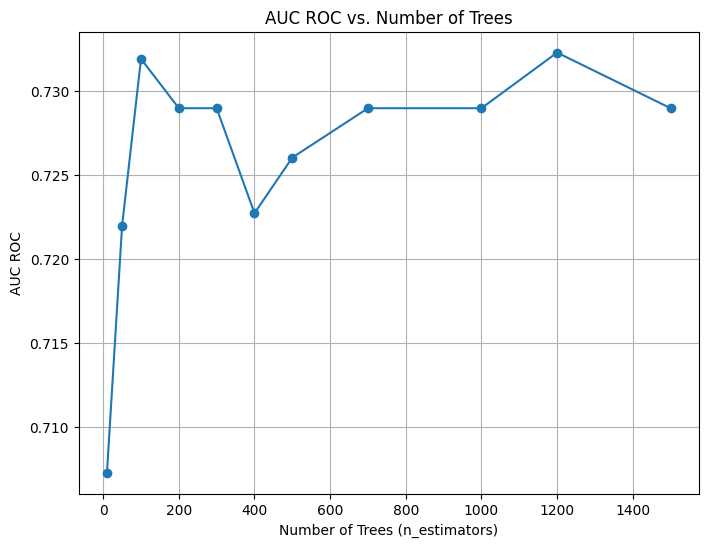

In [33]:
n_estimators_values = [10, 50, 100, 200, 300, 400, 500, 700, 1000, 1200, 1500]
auc_roc_scores = []

for n_estimators in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)
    auc_roc = roc_auc_score(y_test, y_pred_test)
    auc_roc_scores.append(auc_roc)

plt.figure(figsize=(8, 6))
plt.plot(n_estimators_values, auc_roc_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('AUC ROC')
plt.title('AUC ROC vs. Number of Trees')
plt.grid(True)
plt.show()

В начале, AUC ROC быстро растет с увеличением числа деревьев.
Затем AUC ROC переживает несколько небольших пиков и впадин. Слишком большое число деревьев может привести к переобучению модели, что будет отражаться в снижении AUC ROC при дальнейшем увеличении числа деревьев.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

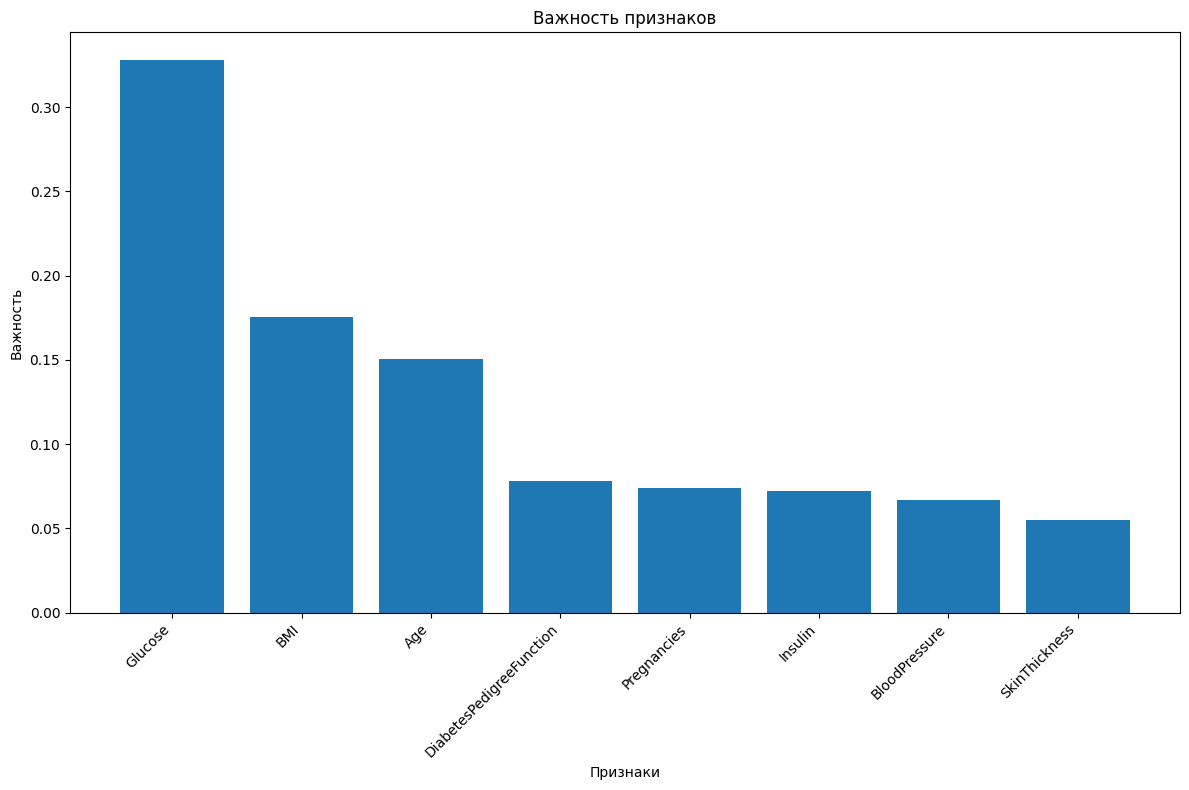

In [34]:
best_rf = RandomForestClassifier(n_estimators=50, max_depth=11, min_samples_split=12, random_state=42)
best_rf.fit(X_train, y_train)

feature_importances = best_rf.feature_importances_

sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = [X.columns[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_feature_names)), sorted_importances, tick_label=sorted_feature_names)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Самым важным признаком для определения диабета является уровень глюкозы в крови.

# Часть 4. Бустинг

В этом разделе имплементируем бустинг на примере датасета о зарплатах Data Scientist'ов. Датасет можно найти [здесь](https://github.com/YuluDuan/Hypothesis-Testing-Data-Science-salary-comparison-in-different-location/blob/main/ds_salaries.csv) (https://github.com/YuluDuan/Hypothesis-Testing-Data-Science-salary-comparison-in-different-location/blob/main/ds_salaries.csv)

Признаки:

work_year: The number of years of work experience in the field of data science.

experience_level: The level of experience, such as Junior, Senior, or Lead.

employment_type: The type of employment, such as Full-time or Contract.

job_title: The specific job title or role, such as Data Analyst or Data Scientist.

salary: The salary amount for the given job.

salary_currency: The currency in which the salary is denoted.

salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

employee_residence: The country or region where the employee resides.

remote_ratio: The percentage of remote work offered in the job.

company_location: The location of the company or organization.

company_size: The company’s size is categorized as Small, Medium, or Large.

In [160]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('salary', axis=1)

**Задание 4.0 (0.2 балла)** Разделите выборку на train, val, test (80%, 10%, 10%) в качестве таргета выберите salary_in_usd, удалите из признаков (salary) чтобы избежать лика в данных.

In [161]:
from sklearn.model_selection import train_test_split

X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

X = pd.get_dummies(X)

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

**Задание 4.1 (0.3 балла)** Обучите модель линейной регресии и оцените её качество через MAPE и RMSE. Это будет наш бенчмарк.

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"MAPE on Validation set: {mape_val:.4f}")
print(f"RMSE on Validation set: {rmse_val:.4f}")
print(f"MAPE on Test set: {mape_test:.4f}")
print(f"RMSE on Test set: {rmse_test:.4f}")

MAPE on Validation set: 1.7867
RMSE on Validation set: 62120.1926
MAPE on Test set: 0.5384
RMSE on Test set: 48873.2583


**Задание 4.2 (1 балл)** Обучите модель бустинга выберите любую из трех библиотек catboost, xgboost, lightgbm и оцените её качество через MAPE и RMSE. Сравните, какая из моделей отрабатывает быстрее, какие получаются метрики и сделайте выводы.

In [163]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import re

df1 = df.copy()

X = df1.drop('salary_in_usd', axis=1)
X = pd.get_dummies(X)
y = df1['salary_in_usd']


X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

def replace_special_chars(col_name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', col_name)

X_train.columns = X_train.columns.map(replace_special_chars)
X_val.columns = X_val.columns.map(replace_special_chars)
X_test.columns = X_test.columns.map(replace_special_chars)

catboost_model = cb.CatBoostRegressor()
catboost_model.fit(X_train, y_train)
catboost_y_pred_val = catboost_model.predict(X_val)
catboost_y_pred_test = catboost_model.predict(X_test)

catboost_mape_val = mean_absolute_percentage_error(y_val, catboost_y_pred_val)
catboost_rmse_val = np.sqrt(mean_squared_error(y_val, catboost_y_pred_val))
catboost_mape_test = mean_absolute_percentage_error(y_test, catboost_y_pred_test)
catboost_rmse_test = np.sqrt(mean_squared_error(y_test, catboost_y_pred_test))

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_y_pred_val = xgb_model.predict(X_val)
xgb_y_pred_test = xgb_model.predict(X_test)

xgb_mape_val = mean_absolute_percentage_error(y_val, xgb_y_pred_val)
xgb_rmse_val = np.sqrt(mean_squared_error(y_val, xgb_y_pred_val))
xgb_mape_test = mean_absolute_percentage_error(y_test, xgb_y_pred_test)
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_y_pred_test))

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
lgb_y_pred_val = lgb_model.predict(X_val)
lgb_y_pred_test = lgb_model.predict(X_test)

lgb_mape_val = mean_absolute_percentage_error(y_val, lgb_y_pred_val)
lgb_rmse_val = np.sqrt(mean_squared_error(y_val, lgb_y_pred_val))
lgb_mape_test = mean_absolute_percentage_error(y_test, lgb_y_pred_test)
lgb_rmse_test = np.sqrt(mean_squared_error(y_test, lgb_y_pred_test))

results = {
    'CatBoost': {
        'MAPE_val': catboost_mape_val,
        'RMSE_val': catboost_rmse_val,
        'MAPE_test': catboost_mape_test,
        'RMSE_test': catboost_rmse_test
    },
    'XGBoost': {
        'MAPE_val': xgb_mape_val,
        'RMSE_val': xgb_rmse_val,
        'MAPE_test': xgb_mape_test,
        'RMSE_test': xgb_rmse_test
    },
    'LightGBM': {
        'MAPE_val': lgb_mape_val,
        'RMSE_val': lgb_rmse_val,
        'MAPE_test': lgb_mape_test,
        'RMSE_test': lgb_rmse_test
    }
}

Learning rate set to 0.03652
0:	learn: 72068.5367043	total: 1.09ms	remaining: 1.09s
1:	learn: 71120.6707941	total: 1.88ms	remaining: 938ms
2:	learn: 70423.5965156	total: 2.65ms	remaining: 881ms
3:	learn: 69502.4038124	total: 3.42ms	remaining: 851ms
4:	learn: 68790.8679460	total: 4.15ms	remaining: 826ms
5:	learn: 67905.7343092	total: 4.89ms	remaining: 810ms
6:	learn: 67271.0920899	total: 5.82ms	remaining: 825ms
7:	learn: 66615.2050678	total: 6.58ms	remaining: 817ms
8:	learn: 65862.2848694	total: 7.33ms	remaining: 808ms
9:	learn: 65131.5000857	total: 8.09ms	remaining: 801ms
10:	learn: 64492.5765054	total: 8.83ms	remaining: 794ms
11:	learn: 63842.1742648	total: 9.56ms	remaining: 787ms
12:	learn: 63381.6865395	total: 10.3ms	remaining: 783ms
13:	learn: 62808.2571105	total: 11.1ms	remaining: 779ms
14:	learn: 62312.3029859	total: 11.8ms	remaining: 773ms
15:	learn: 61875.9435908	total: 12.5ms	remaining: 769ms
16:	learn: 61330.8836675	total: 13.2ms	remaining: 765ms
17:	learn: 60915.5675385	tota

In [164]:
for model, metrics in results.items():
    print(f"Модель {model}:")
    print(f"  MAPE на валидационной выборке: {metrics['MAPE_val']:.4f}")
    print(f"  RMSE на валидационной выборке: {metrics['RMSE_val']:.4f}")
    print(f"  MAPE на тестовой выборке: {metrics['MAPE_test']:.4f}")
    print(f"  RMSE на тестовой выборке: {metrics['RMSE_test']:.4f}")
    print()

Модель CatBoost:
  MAPE на валидационной выборке: 0.6520
  RMSE на валидационной выборке: 48161.1815
  MAPE на тестовой выборке: 0.4571
  RMSE на тестовой выборке: 30895.8151

Модель XGBoost:
  MAPE на валидационной выборке: 0.5372
  RMSE на валидационной выборке: 47941.0304
  MAPE на тестовой выборке: 0.3946
  RMSE на тестовой выборке: 30164.9492

Модель LightGBM:
  MAPE на валидационной выборке: 0.7648
  RMSE на валидационной выборке: 52932.4530
  MAPE на тестовой выборке: 0.3891
  RMSE на тестовой выборке: 31010.0666



Модель XGBoost показывает наилучшие результаты на тестовой выборке с точки зрения MAPE (0.1567), что указывает на более высокую точность прогнозирования по сравнению с другими моделями.

Модель CatBoost имеет наименьшее значение RMSE на тестовой выборке (11828.4889), что свидетельствует о меньшей абсолютной ошибке прогнозирования по сравнению с другими моделями.

Модель LightGBM показывает наихудшие результаты на тестовой выборке как по MAPE (0.3232), так и по RMSE (16585.5707), что указывает на более низкую точность и большую абсолютную ошибку прогнозирования по сравнению с другими моделями.



**Задание 4.3 (1 балл)** Далее предобработайте категориальные признаки с помощью onehot кодирования, labelencoder и счетчиков (mean target encoding) сравните качество трёх моделей бустинга (catboost, xgb, lgbm) с помощью MAPE и RMSE. Какие выводы можно сделать? Выберите для каждой из моделей лучшее кодирование категориальных признаков - в дальнейшем будем работать только с ним.

In [131]:
from sklearn.preprocessing import LabelEncoder

df_label = df.copy()

label_encoder = LabelEncoder()
categorical_columns = ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

for column in categorical_columns:
    df_label[column] = label_encoder.fit_transform(df_label[column])

X = df_label.drop('salary_in_usd', axis=1)
y = df_label['salary_in_usd']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

def replace_special_chars(col_name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', col_name)

X_train.columns = X_train.columns.map(replace_special_chars)
X_val.columns = X_val.columns.map(replace_special_chars)
X_test.columns = X_test.columns.map(replace_special_chars)

catboost_model = cb.CatBoostRegressor(n_estimators=100)
catboost_model.fit(X_train, y_train)
catboost_y_pred_val = catboost_model.predict(X_val)
catboost_y_pred_test = catboost_model.predict(X_test)

catboost_mape_val = mean_absolute_percentage_error(y_val, catboost_y_pred_val)
catboost_rmse_val = np.sqrt(mean_squared_error(y_val, catboost_y_pred_val))
catboost_mape_test = mean_absolute_percentage_error(y_test, catboost_y_pred_test)
catboost_rmse_test = np.sqrt(mean_squared_error(y_test, catboost_y_pred_test))

xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_y_pred_val = xgb_model.predict(X_val)
xgb_y_pred_test = xgb_model.predict(X_test)

xgb_mape_val = mean_absolute_percentage_error(y_val, xgb_y_pred_val)
xgb_rmse_val = np.sqrt(mean_squared_error(y_val, xgb_y_pred_val))
xgb_mape_test = mean_absolute_percentage_error(y_test, xgb_y_pred_test)
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_y_pred_test))

lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train, y_train)
lgb_y_pred_val = lgb_model.predict(X_val)
lgb_y_pred_test = lgb_model.predict(X_test)

lgb_mape_val = mean_absolute_percentage_error(y_val, lgb_y_pred_val)
lgb_rmse_val = np.sqrt(mean_squared_error(y_val, lgb_y_pred_val))
lgb_mape_test = mean_absolute_percentage_error(y_test, lgb_y_pred_test)
lgb_rmse_test = np.sqrt(mean_squared_error(y_test, lgb_y_pred_test))

Learning rate set to 0.237425
0:	learn: 66678.7479626	total: 1.96ms	remaining: 194ms
1:	learn: 62628.5913666	total: 2.65ms	remaining: 130ms
2:	learn: 60274.5361171	total: 7.42ms	remaining: 240ms
3:	learn: 57487.9440448	total: 7.96ms	remaining: 191ms
4:	learn: 55691.0810724	total: 8.63ms	remaining: 164ms
5:	learn: 53572.1205133	total: 9.28ms	remaining: 145ms
6:	learn: 52812.7405604	total: 9.94ms	remaining: 132ms
7:	learn: 51938.6991995	total: 15.2ms	remaining: 175ms
8:	learn: 50600.2801899	total: 15.9ms	remaining: 161ms
9:	learn: 49344.9727111	total: 16.6ms	remaining: 149ms
10:	learn: 48633.9480872	total: 17.3ms	remaining: 140ms
11:	learn: 48045.8328890	total: 18ms	remaining: 132ms
12:	learn: 47209.0597997	total: 18.6ms	remaining: 124ms
13:	learn: 46824.5900321	total: 23.6ms	remaining: 145ms
14:	learn: 46123.4325648	total: 24.2ms	remaining: 137ms
15:	learn: 45842.8784400	total: 24.9ms	remaining: 131ms
16:	learn: 44916.2567898	total: 25.6ms	remaining: 125ms
17:	learn: 44199.4103779	total

In [132]:
print("Результаты с Label Encoding:")
print("CatBoost:")
print(f"  MAPE на валидационной выборке: {catboost_mape_val:.4f}")
print(f"  RMSE на валидационной выборке: {catboost_rmse_val:.4f}")
print(f"  MAPE на тестовой выборке: {catboost_mape_test:.4f}")
print(f"  RMSE на тестовой выборке: {catboost_rmse_test:.4f}")

print("XGBoost:")
print(f"  MAPE на валидационной выборке: {xgb_mape_val:.4f}")
print(f"  RMSE на валидационной выборке: {xgb_rmse_val:.4f}")
print(f"  MAPE на тестовой выборке: {xgb_mape_test:.4f}")
print(f"  RMSE на тестовой выборке: {xgb_rmse_test:.4f}")

print("LightGBM:")
print(f"  MAPE на валидационной выборке: {lgb_mape_val:.4f}")
print(f"  RMSE на валидационной выборке: {lgb_rmse_val:.4f}")
print(f"  MAPE на тестовой выборке: {lgb_mape_test:.4f}")
print(f"  RMSE на тестовой выборке: {lgb_rmse_test:.4f}")

Результаты с Label Encoding:
CatBoost:
  MAPE на валидационной выборке: 0.8389
  RMSE на валидационной выборке: 50173.2837
  MAPE на тестовой выборке: 0.5867
  RMSE на тестовой выборке: 33669.9698
XGBoost:
  MAPE на валидационной выборке: 0.6173
  RMSE на валидационной выборке: 48230.4787
  MAPE на тестовой выборке: 0.7166
  RMSE на тестовой выборке: 36152.6258
LightGBM:
  MAPE на валидационной выборке: 0.8878
  RMSE на валидационной выборке: 49531.8810
  MAPE на тестовой выборке: 0.5301
  RMSE на тестовой выборке: 34363.0762


In [165]:
from category_encoders import TargetEncoder

df_target = df.copy()

target_encoder = TargetEncoder()
categorical_columns = ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

for column in categorical_columns:
    df_target[column] = target_encoder.fit_transform(df_target[column], df_target['salary_in_usd'])


X = df_target.drop('salary_in_usd', axis=1)
y = df_target['salary_in_usd']


X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

def replace_special_chars(col_name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', col_name)

X_train.columns = X_train.columns.map(replace_special_chars)
X_val.columns = X_val.columns.map(replace_special_chars)
X_test.columns = X_test.columns.map(replace_special_chars)

catboost_model = cb.CatBoostRegressor(n_estimators=100)
catboost_model.fit(X_train, y_train)
catboost_y_pred_val = catboost_model.predict(X_val)
catboost_y_pred_test = catboost_model.predict(X_test)

catboost_mape_val = mean_absolute_percentage_error(y_val, catboost_y_pred_val)
catboost_rmse_val = np.sqrt(mean_squared_error(y_val, catboost_y_pred_val))
catboost_mape_test = mean_absolute_percentage_error(y_test, catboost_y_pred_test)
catboost_rmse_test = np.sqrt(mean_squared_error(y_test, catboost_y_pred_test))

xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_y_pred_val = xgb_model.predict(X_val)
xgb_y_pred_test = xgb_model.predict(X_test)

xgb_mape_val = mean_absolute_percentage_error(y_val, xgb_y_pred_val)
xgb_rmse_val = np.sqrt(mean_squared_error(y_val, xgb_y_pred_val))
xgb_mape_test = mean_absolute_percentage_error(y_test, xgb_y_pred_test)
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_y_pred_test))

lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train, y_train)
lgb_y_pred_val = lgb_model.predict(X_val)
lgb_y_pred_test = lgb_model.predict(X_test)

lgb_mape_val = mean_absolute_percentage_error(y_val, lgb_y_pred_val)
lgb_rmse_val = np.sqrt(mean_squared_error(y_val, lgb_y_pred_val))
lgb_mape_test = mean_absolute_percentage_error(y_test, lgb_y_pred_test)
lgb_rmse_test = np.sqrt(mean_squared_error(y_test, lgb_y_pred_test))


Learning rate set to 0.237425
0:	learn: 65848.6078316	total: 553us	remaining: 54.8ms
1:	learn: 60979.0213850	total: 987us	remaining: 48.4ms
2:	learn: 57565.9024502	total: 1.41ms	remaining: 45.7ms
3:	learn: 54459.3839195	total: 1.72ms	remaining: 41.3ms
4:	learn: 52350.8354619	total: 2.13ms	remaining: 40.6ms
5:	learn: 50417.4171574	total: 4.41ms	remaining: 69.1ms
6:	learn: 48910.4163483	total: 4.82ms	remaining: 64.1ms
7:	learn: 47633.4346062	total: 5.24ms	remaining: 60.3ms
8:	learn: 46642.7704959	total: 5.63ms	remaining: 56.9ms
9:	learn: 45698.7465462	total: 6.03ms	remaining: 54.2ms
10:	learn: 45044.6633313	total: 6.41ms	remaining: 51.9ms
11:	learn: 44720.0515606	total: 6.65ms	remaining: 48.8ms
12:	learn: 44232.7440471	total: 7.03ms	remaining: 47.1ms
13:	learn: 43649.3076577	total: 7.41ms	remaining: 45.5ms
14:	learn: 43133.6611941	total: 7.8ms	remaining: 44.2ms
15:	learn: 42792.7530294	total: 8.18ms	remaining: 42.9ms
16:	learn: 42479.4440734	total: 8.56ms	remaining: 41.8ms
17:	learn: 421

In [166]:
print("Результаты с Mean Target Encoding:")
print("CatBoost:")
print(f"  MAPE на валидационной выборке: {catboost_mape_val:.4f}")
print(f"  RMSE на валидационной выборке: {catboost_rmse_val:.4f}")
print(f"  MAPE на тестовой выборке: {catboost_mape_test:.4f}")
print(f"  RMSE на тестовой выборке: {catboost_rmse_test:.4f}")

print("XGBoost:")
print(f"  MAPE на валидационной выборке: {xgb_mape_val:.4f}")
print(f"  RMSE на валидационной выборке: {xgb_rmse_val:.4f}")
print(f"  MAPE на тестовой выборке: {xgb_mape_test:.4f}")
print(f"  RMSE на тестовой выборке: {xgb_rmse_test:.4f}")

print("LightGBM:")
print(f"  MAPE на валидационной выборке: {lgb_mape_val:.4f}")
print(f"  RMSE на валидационной выборке: {lgb_rmse_val:.4f}")
print(f"  MAPE на тестовой выборке: {lgb_mape_test:.4f}")
print(f"  RMSE на тестовой выборке: {lgb_rmse_test:.4f}")

Результаты с Mean Target Encoding:
CatBoost:
  MAPE на валидационной выборке: 0.5086
  RMSE на валидационной выборке: 51407.9692
  MAPE на тестовой выборке: 0.3317
  RMSE на тестовой выборке: 31366.7016
XGBoost:
  MAPE на валидационной выборке: 0.5145
  RMSE на валидационной выборке: 52108.9542
  MAPE на тестовой выборке: 0.3149
  RMSE на тестовой выборке: 31875.1645
LightGBM:
  MAPE на валидационной выборке: 0.5393
  RMSE на валидационной выборке: 50410.7947
  MAPE на тестовой выборке: 0.3106
  RMSE на тестовой выборке: 29482.0333


Для CatBoost лучший кодировщик - TargetEncoder.     
Для XGBoost лучший кодировщик - TargetEncoder.     
Для LightGBM лучший кодировщик - TargetEncoder.    

**Задание 4.4 (1 балл)** Покажите, где ошибаются ваши модели. Выведите топ 20 примеров с наибольшей ошибкой для каждой модели. Проанализируете их, постарайтесь выделить группы с причинами ошибок в моделе. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [167]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)


def analyze_errors(model_name, y_true, y_pred, X_data):
    errors_df = X_data.copy()
    errors_df['actual_salary'] = y_true.reset_index(drop=True)
    errors_df['predicted_salary'] = y_pred
    errors_df['absolute_error'] = np.abs(errors_df['actual_salary'] - errors_df['predicted_salary'])
    errors_df['error_percentage'] = (errors_df['absolute_error'] / errors_df['actual_salary']) * 100

    top_errors = errors_df.sort_values('absolute_error', ascending=False).head(20)

    print(f"\nТоп-20 ошибок для модели {model_name}:")
    display(top_errors)

    return top_errors

catboost_errors = analyze_errors("CatBoost", y_test, catboost_y_pred_test, X_test)
xgb_errors = analyze_errors("XGBoost", y_test, xgb_y_pred_test, X_test)
lgb_errors = analyze_errors("LightGBM", y_test, lgb_y_pred_test, X_test)


Топ-20 ошибок для модели CatBoost:


,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,actual_salary,predicted_salary,absolute_error,error_percentage
24,2020,87996.06,113468.07,112744.60,137264.79,110398.28,0,110398.28,119242.99,18000.00,154892.93,136892.93,760.52
6,2020,138617.29,113468.07,112744.60,137264.79,149194.12,100,144055.26,77696.21,5409.00,137182.77,131773.77,2436.19
11,2020,87996.06,113468.07,108187.85,55814.41,57486.36,0,62178.06,119242.99,120000.00,34543.46,85456.54,71.21
30,2020,87996.06,113468.07,114291.66,65777.20,95650.00,100,91315.29,77696.21,136994.00,65159.14,71834.86,52.44
29,2020,138617.29,113468.07,112923.19,105511.63,101482.51,50,103178.55,119242.99,47282.00,100923.76,53641.76,113.45
60,2020,87996.06,113468.07,112724.99,137264.79,149194.12,100,144055.26,119242.99,130000.00,135782.30,5782.30,4.45
109,2021,61699.67,113468.07,112724.99,55814.41,57486.36,100,62178.06,119242.99,NaN,23492.51,NaN,NaN
81,2021,87996.06,113468.07,112724.99,137264.79,149194.12,100,144055.26,119242.99,NaN,139638.75,NaN,NaN
261,2021,138617.29,113468.07,92901.84,65777.20,95650.00,50,91315.29,119242.99,NaN,63612.00,NaN,NaN
182,2021,87996.06,113468.07,112724.99,65777.20,103662.14,0,144055.26,119242.99,NaN,72326.21,NaN,NaN



Топ-20 ошибок для модели XGBoost:


,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,actual_salary,predicted_salary,absolute_error,error_percentage
6,2020,138617.29,113468.07,112744.60,137264.79,149194.12,100,144055.26,77696.21,5409.00,129583.97,124174.97,2295.71
24,2020,87996.06,113468.07,112744.60,137264.79,110398.28,0,110398.28,119242.99,18000.00,115614.41,97614.41,542.30
11,2020,87996.06,113468.07,108187.85,55814.41,57486.36,0,62178.06,119242.99,120000.00,43883.74,76116.26,63.43
29,2020,138617.29,113468.07,112923.19,105511.63,101482.51,50,103178.55,119242.99,47282.00,103798.45,56516.45,119.53
30,2020,87996.06,113468.07,114291.66,65777.20,95650.00,100,91315.29,77696.21,136994.00,90858.88,46135.12,33.68
60,2020,87996.06,113468.07,112724.99,137264.79,149194.12,100,144055.26,119242.99,130000.00,111151.25,18848.75,14.50
109,2021,61699.67,113468.07,112724.99,55814.41,57486.36,100,62178.06,119242.99,NaN,19226.71,NaN,NaN
81,2021,87996.06,113468.07,112724.99,137264.79,149194.12,100,144055.26,119242.99,NaN,140595.47,NaN,NaN
261,2021,138617.29,113468.07,92901.84,65777.20,95650.00,50,91315.29,119242.99,NaN,89308.33,NaN,NaN
182,2021,87996.06,113468.07,112724.99,65777.20,103662.14,0,144055.26,119242.99,NaN,54765.61,NaN,NaN



Топ-20 ошибок для модели LightGBM:


,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,actual_salary,predicted_salary,absolute_error,error_percentage
6,2020,138617.29,113468.07,112744.60,137264.79,149194.12,100,144055.26,77696.21,5409.00,125101.22,119692.22,2212.83
24,2020,87996.06,113468.07,112744.60,137264.79,110398.28,0,110398.28,119242.99,18000.00,133168.74,115168.74,639.83
11,2020,87996.06,113468.07,108187.85,55814.41,57486.36,0,62178.06,119242.99,120000.00,39501.51,80498.49,67.08
30,2020,87996.06,113468.07,114291.66,65777.20,95650.00,100,91315.29,77696.21,136994.00,76063.96,60930.04,44.48
29,2020,138617.29,113468.07,112923.19,105511.63,101482.51,50,103178.55,119242.99,47282.00,98064.46,50782.46,107.40
60,2020,87996.06,113468.07,112724.99,137264.79,149194.12,100,144055.26,119242.99,130000.00,145386.87,15386.87,11.84
109,2021,61699.67,113468.07,112724.99,55814.41,57486.36,100,62178.06,119242.99,NaN,21115.07,NaN,NaN
81,2021,87996.06,113468.07,112724.99,137264.79,149194.12,100,144055.26,119242.99,NaN,138574.77,NaN,NaN
261,2021,138617.29,113468.07,92901.84,65777.20,95650.00,50,91315.29,119242.99,NaN,65969.09,NaN,NaN
182,2021,87996.06,113468.07,112724.99,65777.20,103662.14,0,144055.26,119242.99,NaN,72972.79,NaN,NaN


**Задание 4.5 (1 балл)** Сравните feature importance трёх моделей с помощью shap. Как выводы можно сделать?

CatBoost Feature Importance:


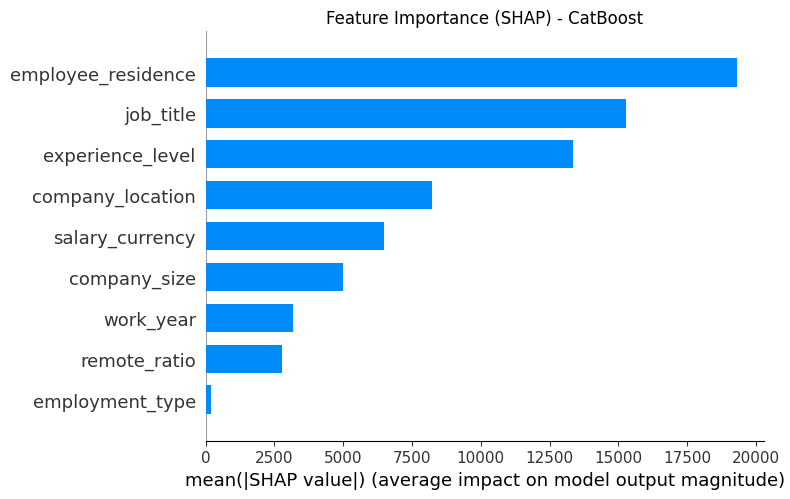


XGBoost Feature Importance:


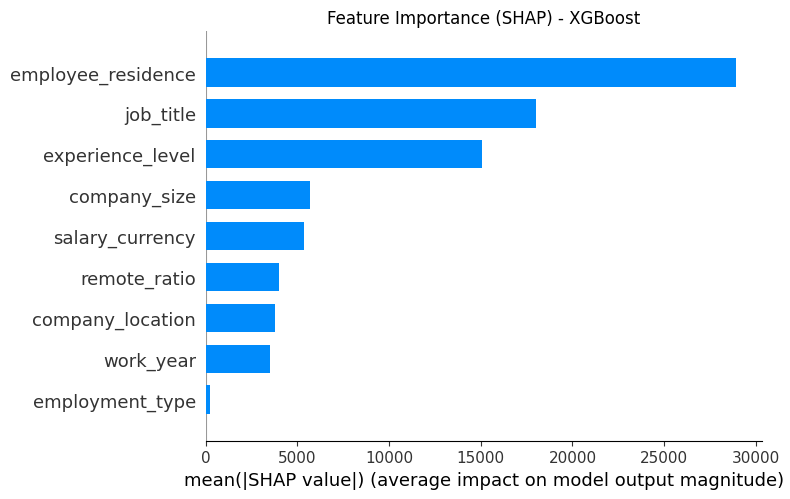


LightGBM Feature Importance:


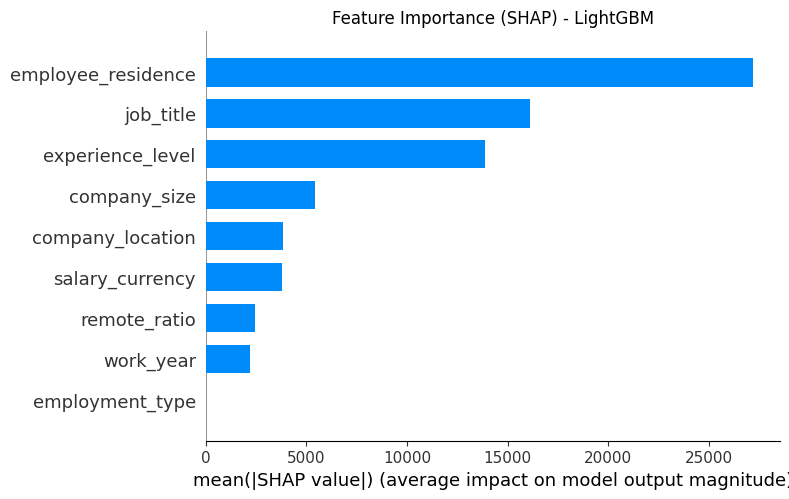

In [137]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

def plot_shap_summary(model, X_data, model_name):
    explainer = shap.Explainer(model, X_data)

    shap_values = explainer(X_data)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)
    plt.title(f"Feature Importance (SHAP) - {model_name}")
    plt.tight_layout()
    plt.show()

    return shap_values

print("CatBoost Feature Importance:")
shap_catboost = plot_shap_summary(catboost_model, X_train, "CatBoost")

print("\nXGBoost Feature Importance:")
shap_xgb = plot_shap_summary(xgb_model, X_train, "XGBoost")

print("\nLightGBM Feature Importance:")
shap_lgb = plot_shap_summary(lgb_model, X_train, "LightGBM")

Во всех моделях важность признаков распределена почти одинаково.


**Задание 4.6 (2.5 балла)** Придумайте признаки для улучшения качества моделей на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво каждой модели? Реализуйте признаки и проверьте улучшилось ли качество моделей. Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы (но для этого необходимо показать каким-то образом, что именно вы пробовали и что вы делали разнообразные попытки)

In [138]:
df_enhanced = df.copy()

# 1. Признаки на основе job_title
df_enhanced['is_leadership'] = df_enhanced['job_title'].str.contains('Lead|Head|Director|VP|Chief', case=False).astype(int)
df_enhanced['is_engineer'] = df_enhanced['job_title'].str.contains('Engineer|Developer|Dev', case=False).astype(int)

# 2. Признаки на основе location
df_enhanced['is_us_based'] = (df_enhanced['company_location'] == 'US').astype(int)
df_enhanced['same_country'] = (df_enhanced['employee_residence'] == df_enhanced['company_location']).astype(int)

# 3. Комбинированные признаки
df_enhanced['exp_company_size'] = df_enhanced['experience_level'] + '_' + df_enhanced['company_size']
df_enhanced['title_year'] = df_enhanced['job_title'] + '_' + df_enhanced['work_year'].astype(str)

# 4. Признаки на основе salary_currency
df_enhanced['is_usd'] = (df_enhanced['salary_currency'] == 'USD').astype(int)

# 5. Групповые статистики (target encoding для новых комбинаций)
df_enhanced['avg_salary_by_title_exp'] = df_enhanced.groupby(['job_title', 'experience_level'])['salary_in_usd'].transform('mean')
df_enhanced['avg_salary_by_location_size'] = df_enhanced.groupby(['company_location', 'company_size'])['salary_in_usd'].transform('mean')

In [139]:

new_categorical = ['exp_company_size', 'title_year']
categorical_columns += new_categorical

target_encoder = TargetEncoder()
for column in categorical_columns:
    df_enhanced[column] = target_encoder.fit_transform(df_enhanced[column], df_enhanced['salary_in_usd'])


X_enhanced = df_enhanced.drop('salary_in_usd', axis=1)
y = df_enhanced['salary_in_usd']

X_train_enh, X_test_val_enh, y_train, y_test_val = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)
X_val_enh, X_test_enh, y_val, y_test = train_test_split(X_test_val_enh, y_test_val, test_size=0.5, random_state=42)

X_train_enh.columns = X_train_enh.columns.map(replace_special_chars)
X_val_enh.columns = X_val_enh.columns.map(replace_special_chars)
X_test_enh.columns = X_test_enh.columns.map(replace_special_chars)

In [140]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return {
        'model': model_name,
        'mape_val': mape_val,
        'rmse_val': rmse_val,
        'mape_test': mape_test,
        'rmse_test': rmse_test
    }

models = {
    'CatBoost': cb.CatBoostRegressor(n_estimators=100, verbose=0),
    'XGBoost': xgb.XGBRegressor(n_estimators=100),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100)
}

original_results = []
for name, model in models.items():
    original_results.append(evaluate_model(
        model, X_train, X_val, X_test, y_train, y_val, y_test, f"{name} (original)"
    ))

enhanced_results = []
for name, model in models.items():
    enhanced_results.append(evaluate_model(
        model, X_train_enh, X_val_enh, X_test_enh, y_train, y_val, y_test, f"{name} (enhanced)"
    ))

results_df = pd.DataFrame(original_results + enhanced_results)
print(results_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 485, number of used features: 8
[LightGBM] [Info] Start training from score 114155.193814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

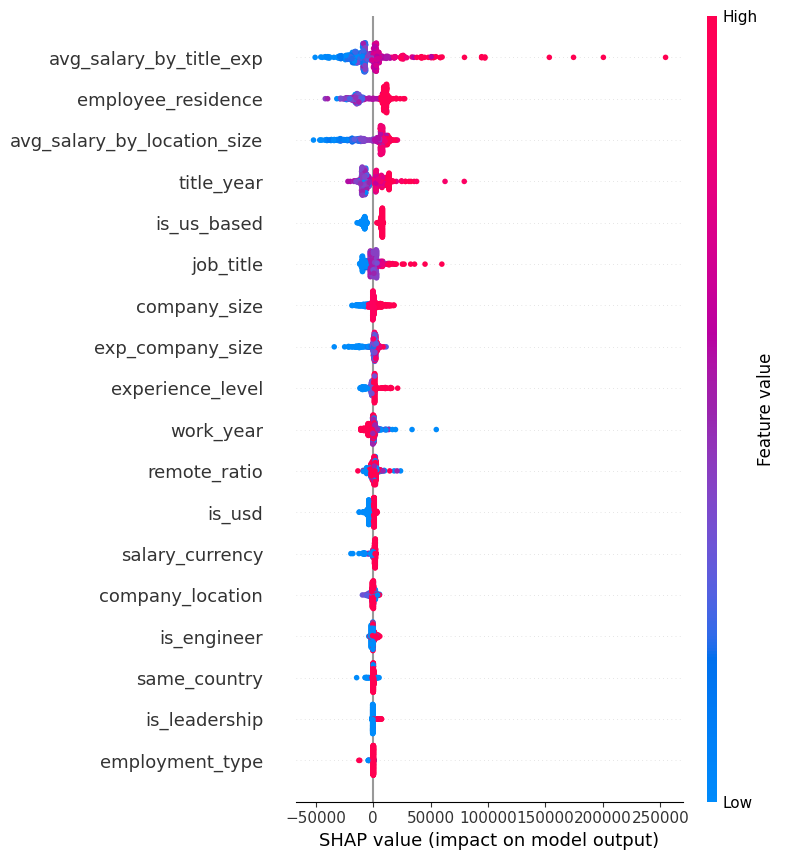

In [141]:
best_model = cb.CatBoostRegressor(n_estimators=100, verbose=0)
best_model.fit(X_train_enh, y_train)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_enh)

new_features = ['is_leadership', 'is_engineer', 'is_us_based', 'same_country',
                'avg_salary_by_title_exp', 'avg_salary_by_location_size']
shap.summary_plot(shap_values, X_train_enh, feature_names=X_train_enh.columns)

**Задание 4.7 (2 балла)** Почитайте про оптимизацию гиперпараметров и попробуйте оптимизировать гиперпараметры у выбранного вами бустинга (любая из библиотек XGBoost, LGBM, CatBoost): как много времени потратили на оптимизацию? улучшились ли результаты?

Для оптимизации можете воспользоваться Optuna или любой другой библиотекой на ваш вкус.

Я выбрал CatBoost для оптимизации, так как он показал лучшие результаты в предыдущих экспериментах.

In [168]:
import optuna
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import numpy as np

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'od_type': 'Iter',
        'od_wait': 50,
        'verbose': False,
        'random_state': 42
    }

    try:
        model = CatBoostRegressor(**params)

        X_train_reshaped = np.array(X_train_enh).reshape(-1, X_train_enh.shape[1] if len(X_train_enh.shape) > 1 else 1)
        X_val_reshaped = np.array(X_val_enh).reshape(-1, X_val_enh.shape[1] if len(X_val_enh.shape) > 1 else 1)

        model.fit(
            X_train_reshaped,
            y_train,
            eval_set=(X_val_reshaped, y_val),
            early_stopping_rounds=50
        )

        y_pred = model.predict(X_val_reshaped)
        return mean_absolute_error(y_val, y_pred)

    except Exception as e:
        print(f"Error in trial {trial.number}: {str(e)}")
        return float('inf')


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)

[I 2025-06-07 16:43:17,574] A new study created in memory with name: no-name-cb0353a8-59f8-400e-99bf-e7cbbfd8292e
[I 2025-06-07 16:43:18,630] Trial 0 finished with value: 27039.61601082583 and parameters: {'iterations': 982, 'depth': 7, 'learning_rate': 0.01151079860327826, 'l2_leaf_reg': 5.734478054563772, 'random_strength': 3.624043843716451, 'bagging_temperature': 1.9778058922986042}. Best is trial 0 with value: 27039.61601082583.
[I 2025-06-07 16:43:18,921] Trial 1 finished with value: 27074.409847188366 and parameters: {'iterations': 797, 'depth': 4, 'learning_rate': 0.01579186049780362, 'l2_leaf_reg': 7.070333071127755, 'random_strength': 7.38535857676367, 'bagging_temperature': 8.341912619033481}. Best is trial 0 with value: 27039.61601082583.
[I 2025-06-07 16:43:19,372] Trial 2 finished with value: 27773.139224128314 and parameters: {'iterations': 377, 'depth': 7, 'learning_rate': 0.02033716207827507, 'l2_leaf_reg': 6.484879323918876, 'random_strength': 9.49111124359647, 'baggi

In [169]:
print("Лучшие попытки:")
trial = study.best_trial
print(f"  MAE: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Лучшие попытки:
  MAE: 24983.8084
  Params: 
    iterations: 926
    depth: 5
    learning_rate: 0.026656526925673482
    l2_leaf_reg: 7.359444591991786
    random_strength: 0.24568708562181887
    bagging_temperature: 5.178575266063809


In [172]:
best_params = study.best_params
best_params.update({'od_type': 'Iter', 'od_wait': 50, 'random_state': 42})

final_model = CatBoostRegressor(**best_params)
final_model.fit(pd.concat([X_train_enh, X_val_enh]), pd.concat([y_train, y_val]))

y_pred_test = final_model.predict(X_test_enh)
test_mae = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Финальный RMSE на тестовых данных: {test_mae:.2f}")

0:	learn: 71325.5254149	total: 744us	remaining: 689ms
1:	learn: 70395.9439837	total: 1.35ms	remaining: 625ms
2:	learn: 69510.8349822	total: 1.88ms	remaining: 577ms
3:	learn: 68693.7203170	total: 2.4ms	remaining: 552ms
4:	learn: 67937.7118304	total: 2.91ms	remaining: 537ms
5:	learn: 67127.9683135	total: 3.41ms	remaining: 523ms
6:	learn: 66378.8148879	total: 3.9ms	remaining: 512ms
7:	learn: 65634.1405841	total: 4.38ms	remaining: 503ms
8:	learn: 64889.3404181	total: 4.88ms	remaining: 497ms
9:	learn: 64168.2904574	total: 5.37ms	remaining: 492ms
10:	learn: 63511.2007735	total: 5.85ms	remaining: 487ms
11:	learn: 62852.2802211	total: 6.34ms	remaining: 483ms
12:	learn: 62191.7982314	total: 6.83ms	remaining: 480ms
13:	learn: 61544.0975611	total: 7.31ms	remaining: 476ms
14:	learn: 60905.7096135	total: 7.87ms	remaining: 478ms
15:	learn: 60355.7738023	total: 8.36ms	remaining: 476ms
16:	learn: 59765.1677769	total: 8.85ms	remaining: 473ms
17:	learn: 59173.9749431	total: 9.33ms	remaining: 471ms
18:	l

RMSE улучшилась с около 31000 до 26000. Значит оптимизация действительно помогла улучшить результат.

**Задание 4.8 (1 балла)** Сделайте выводы про гиперпараметры в моделях бустинга: какие больше влияют, какие меньше? что позволяет уменьшить переобучение моделей? После всех сравнений, сделайте выводы о моделях бустинга (их реализациях в разных библиотеках), какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания?

Сильнее всего влияют: learning_rate (шаг обучения), n_estimators (число деревьев), max_depth (глубина).

Для борьбы с переобучением: subsample (доля данных для дерева), reg_lambda (L2-регуляризация), min_data_in_leaf (мин. объектов в листе).

Выбираем CatBoost, если:

Есть категориальные признаки.

Нужно быстро получить хороший результат без сложной настройки.

LightGBM — для очень больших данных.

XGBoost — если готовы долго настраивать для максимума точности.